##### Copyright 2023 The MediaPipe Authors. All Rights Reserved.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Pose Landmarks Detection with MediaPipe Tasks

This notebook shows you how to use MediaPipe Tasks Python API to detect pose landmarks from images.

## Preparation

Let's start with installing MediaPipe.


In [1]:
!pip install -q mediapipe==0.10.0
!pip install opencv-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.9/33.9 MB 35.1 MB/s eta 0:00:00


Then download an off-the-shelf model bundle. Check out the [MediaPipe documentation](https://developers.google.com/mediapipe/solutions/vision/pose_landmarker#models) for more information about this model bundle.

In [2]:
!wget -O pose_landmarker.task -q https://storage.googleapis.com/mediapipe-models/pose_landmarker/pose_landmarker_heavy/float16/1/pose_landmarker_heavy.task

## Visualization utilities

In [3]:
#@markdown To better demonstrate the Pose Landmarker API, we have created a set of visualization tools that will be used in this colab. These will draw the landmarks on a detect person, as well as the expected connections between those markers.

from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import numpy as np


def draw_landmarks_on_image(rgb_image, detection_result):
  pose_landmarks_list = detection_result.pose_landmarks
  annotated_image = np.copy(rgb_image)

  # Loop through the detected poses to visualize.
  for idx in range(len(pose_landmarks_list)):
    pose_landmarks = pose_landmarks_list[idx]

    # Draw the pose landmarks.
    pose_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    pose_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in pose_landmarks
    ])
    solutions.drawing_utils.draw_landmarks(
      annotated_image,
      pose_landmarks_proto,
      solutions.pose.POSE_CONNECTIONS,
      solutions.drawing_styles.get_default_pose_landmarks_style())
  return annotated_image

## Download test image

To demonstrate the Pose Landmarker API, you can download a sample image using the follow code. The image is from [Pixabay](https://pixabay.com/photos/girl-woman-fitness-beautiful-smile-4051811/).

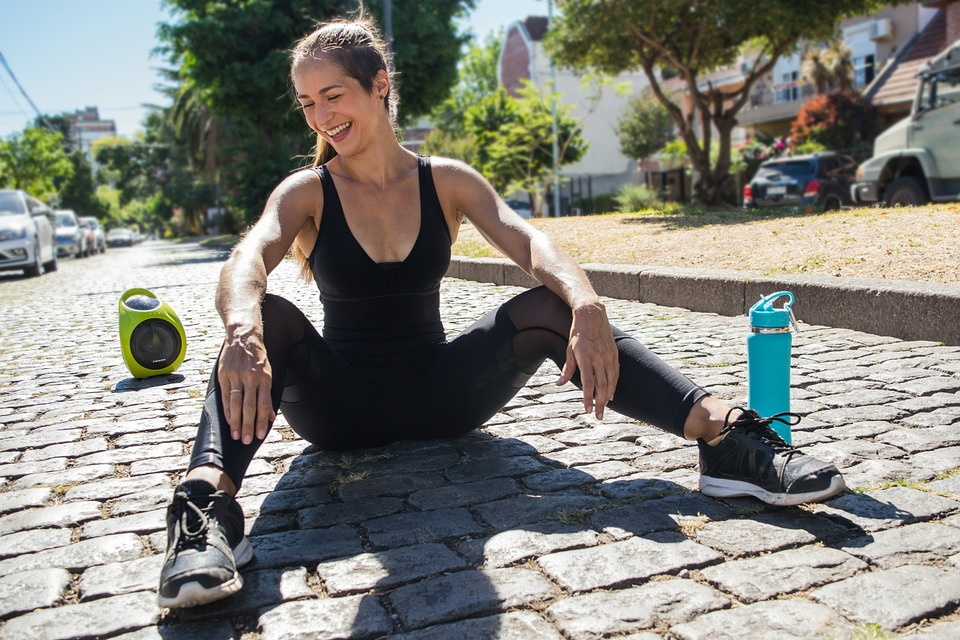

In [4]:
!wget -q -O image.jpg https://cdn.pixabay.com/photo/2019/03/12/20/39/girl-4051811_960_720.jpg

import cv2
from google.colab.patches import cv2_imshow

img = cv2.imread("image.jpg")
cv2_imshow(img)

Optionally, you can upload your own image. If you want to do so, uncomment and run the cell below.

In [5]:
# from google.colab import files
# uploaded = files.upload()

# for filename in uploaded:
#   content = uploaded[filename]
#   with open(filename, 'wb') as f:
#     f.write(content)

# if len(uploaded.keys()):
#   IMAGE_FILE = next(iter(uploaded))
#   print('Uploaded file:', IMAGE_FILE)

## Running inference and visualizing the results

The final step is to run pose landmark detection on your selected image. This involves creating your PoseLandmarker object, loading your image, running detection, and finally, the optional step of displaying the image with visualizations.

Check out the [MediaPipe documentation](https://developers.google.com/mediapipe/solutions/vision/pose_landmarker/python) to learn more about configuration options that this solution supports.


In [12]:
# STEP 1: Import the necessary modules.
import mediapipe as mp
import cv2


# STEP 2: Create an PoseLandmarker object. Create the task.
BaseOptions = mp.tasks.BaseOptions
PoseLandmarker = mp.tasks.vision.PoseLandmarker
PoseLandmarkerOptions = mp.tasks.vision.PoseLandmarkerOptions
VisionRunningMode = mp.tasks.vision.RunningMode
PoseLandmarkerResult = mp.tasks.vision.PoseLandmarkerResult

# Create a pose landmarker instance with the live stream mode
def print_result(result: PoseLandmarkerResult, output_image: mp.Image, timestamp_ms: int):
    print('pose landmarker result: {}'.format(result))

#for image
#options = PoseLandmarkerOptions(base_options=BaseOptions(model_asset_path='pose_landmarker.task'), running_mode=VisionRunningMode.IMAGE)
#for live stream
options = PoseLandmarkerOptions(base_options=BaseOptions(model_asset_path='pose_landmarker.task'),running_mode=VisionRunningMode.LIVE_STREAM,result_callback=print_result)

#landmarker initialized
with PoseLandmarker.create_from_options(options) as landmarker:
  detector = mp.tasks.vision.PoseLandmarker.create_from_options(options)


# STEP 3: Load the input image. Prepare data.
#for image
#image = mp.Image.create_from_file("image.jpg")

#for live stream
#initialize pose estimator
#mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5)

# Use OpenCV’s VideoCapture to start capturing from the webcam.
cap = cv2.VideoCapture(0)

# Loop to read the latest frame from the camera using VideoCapture#read()
while cap.isOpened():
    # read frame
    ret, frame = cap.read()

    if not ret:
      break

    #q to exit
    if cv2.waitKey(1) == ord('q'):
      break

    # Convert the frame received from OpenCV to a MediaPipe’s Image object
    mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=frame)

'''
    try:
         # resize the frame for portrait video
         #frame = cv2.resize(frame, (350, 600))
         # convert to RGB
         frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

         # process the frame for pose detection
         pose_results = pose.process(frame_rgb)
         # print(pose_results.pose_landmarks)

         # draw skeleton on the frame
         if pose_results.pose_landmarks:
          mp_drawing = mp.solutions.drawing_utils
          mp_drawing.draw_landmarks(frame, pose_results.pose_landmarks, mp_pose.POSE_CONNECTIONS)

         # Convert the frame received from OpenCV to a MediaPipe’s Image object
         mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=frame)

         # display the frame
         cv2.imshow('Output', frame)
    except:
         break
'''

# Release/close
cap.release()
cv2.destroyAllWindows()


# STEP 4: Detect pose landmarks from the input image. Run the task.
#for image
#detection_result = detector.detect(image)

#for live stream
# Send live image data to perform pose landmarking.
# The results are accessible via the `result_callback` provided in
# the `PoseLandmarkerOptions` object.
# The pose landmarker must be created with the live stream mode.

#landmarker.detect_async(mp_image, frame_timestamp_ms)


# STEP 5: Process the detection result. In this case, visualize it.
#for image
annotated_image = draw_landmarks_on_image(image.numpy_view(), detection_result)
cv2_imshow(cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))

#for live stream



IndentationError: ignored

Visualize the pose segmentation mask.

In [6]:
segmentation_mask = detection_result.segmentation_masks[0].numpy_view()
visualized_mask = np.repeat(segmentation_mask[:, :, np.newaxis], 3, axis=2) * 255
cv2_imshow(visualized_mask)

NameError: ignored